In [3]:
import os
import tqdm as tqdm
import numpy as np
import copy

# 处理服务器中evo的可视化问题
import evo
from evo.tools.settings import SETTINGS
SETTINGS['plot_backend'] = 'Agg'

from evo.tools import file_interface, plot
from evo.core.geometry import GeometryException
import evo.main_ape as main_ape
from evo.core import sync, metrics
from evo.core.trajectory import PoseTrajectory3D

import matplotlib.pyplot as plt #绘图

print("Successfully import ultils")

Successfully import ultils


In [4]:
def make_evo_traj_gt(poses_N_x_7, tss_us):
    assert poses_N_x_7.shape[1] == 7
    assert poses_N_x_7.shape[0] > 10
    assert tss_us.shape[0] == poses_N_x_7.shape[0]

    traj_evo = PoseTrajectory3D(
        positions_xyz=poses_N_x_7[:,:3],
        # orientations_quat_wxyz=poses_N_x_7[:,3:],
        orientations_quat_wxyz = poses_N_x_7[:, [6,3,4,5]],#gt存储的是xyzw
        timestamps=tss_us/1e6)#转换为秒
    return traj_evo

def make_evo_traj_deio(poses_N_x_7, tss_us):
    assert poses_N_x_7.shape[1] == 7
    assert poses_N_x_7.shape[0] > 10
    assert tss_us.shape[0] == poses_N_x_7.shape[0]

    traj_evo = PoseTrajectory3D(
        positions_xyz=poses_N_x_7[:,:3],
        # orientations_quat_wxyz=poses_N_x_7[:,3:],
        orientations_quat_wxyz = poses_N_x_7[:, [5,6,3,4]],#存储的是yzwx(由于原代码的bug导致的,注意统一代码输出为xyzw而evo中需要用的是wxyz即可)
        timestamps=tss_us/1e6)#转换为秒
    return traj_evo

def load_gt_us(path, skiprows=0):
    traj_ref = np.loadtxt(path, delimiter=" ", skiprows=skiprows)
    tss_gt_us = traj_ref[:, 0].copy() 
    assert np.all(tss_gt_us == sorted(tss_gt_us))
    assert traj_ref.shape[0] > 0
    assert traj_ref.shape[1] == 8

    return tss_gt_us, traj_ref[:, 1:]

def plot_trajectory_inxyplane(pred_traj, gt_traj, align=True, _n_to_align=-1,correct_scale=True, max_diff_sec=1.0,title="", filename=""):
    #将两个轨迹对齐(时间维度上的)
    gt_traj, pred_traj = sync.associate_trajectories(gt_traj, pred_traj, max_diff=max_diff_sec)

    # 对齐轨迹(空间维度上的)
    if align:
        try:
            pred_traj.align(gt_traj, correct_scale=correct_scale,n=_n_to_align)
        except GeometryException as e:
            print("Plotting error:", e)

    plot_collection = plot.PlotCollection("PlotCol")

    fig = plt.figure(figsize=(8, 8))
    plot_mode = plot.PlotMode.xy
    ax = plot.prepare_axis(fig, plot_mode)
    ax.set_title(title)
    if gt_traj is not None:
        plot.traj(ax, plot_mode, gt_traj, '--', 'gray', "Ground Truth")
    plot.traj(ax, plot_mode, pred_traj, '-', 'blue', "Predicted")
    
    plot_collection.add_figure("traj (error)", fig)

    plt.show()

print("Successfully define several functions")

Successfully define several functions


Evaluation for DAVIS240c dataset


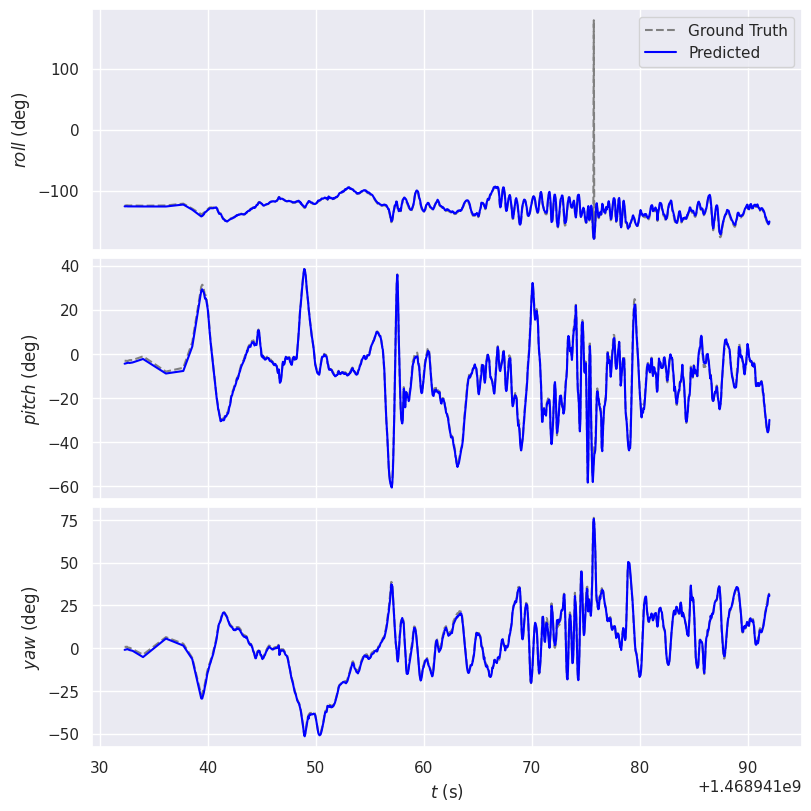

boxes_6dof: 
ATE[cm]: 4.47 | MPE[%/m]: 0.05  | rmse_degree[deg]: 2.08 | MRE[deg/m]: 0.03


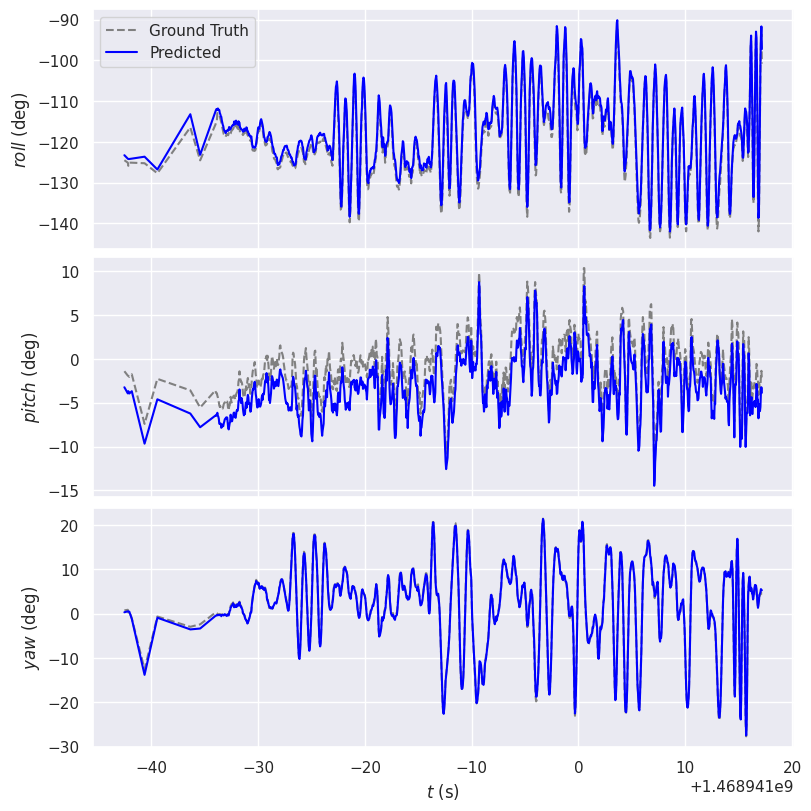

boxes_translation: 
ATE[cm]: 6.69 | MPE[%/m]: 0.07  | rmse_degree[deg]: 2.70 | MRE[deg/m]: 0.04


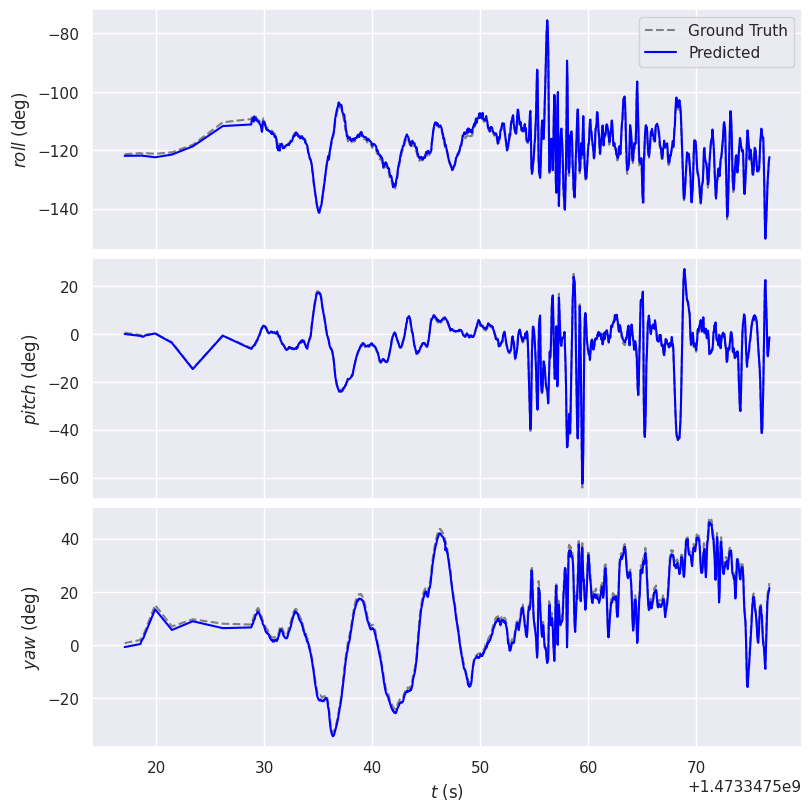

dynamic_6dof: 
ATE[cm]: 1.93 | MPE[%/m]: 0.04  | rmse_degree[deg]: 1.91 | MRE[deg/m]: 0.05


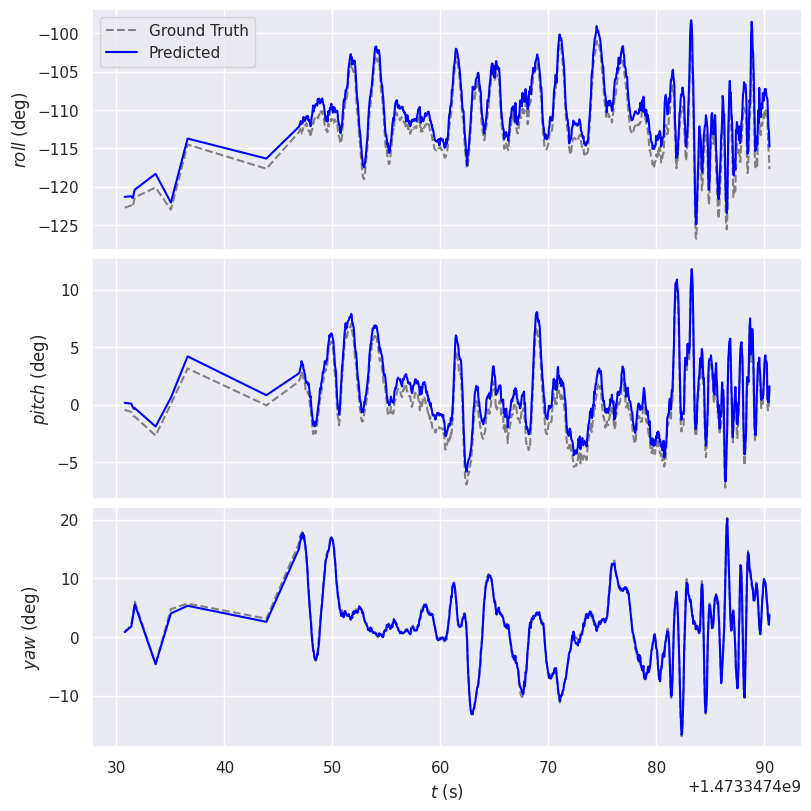

dynamic_translation: 
ATE[cm]: 2.00 | MPE[%/m]: 0.06  | rmse_degree[deg]: 2.04 | MRE[deg/m]: 0.07


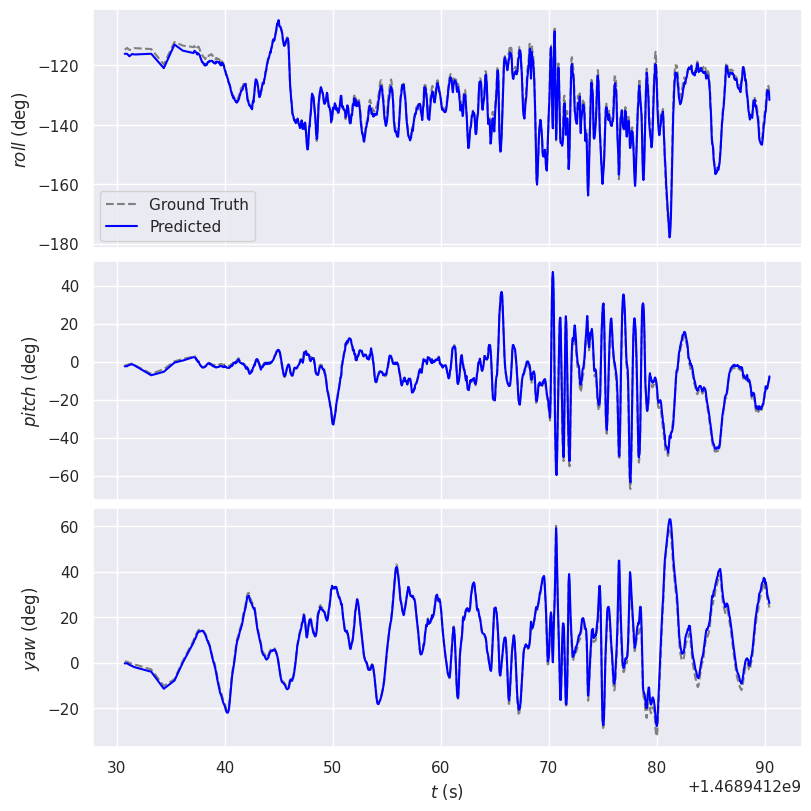

hdr_boxes: 
ATE[cm]: 5.81 | MPE[%/m]: 0.09  | rmse_degree[deg]: 2.66 | MRE[deg/m]: 0.04


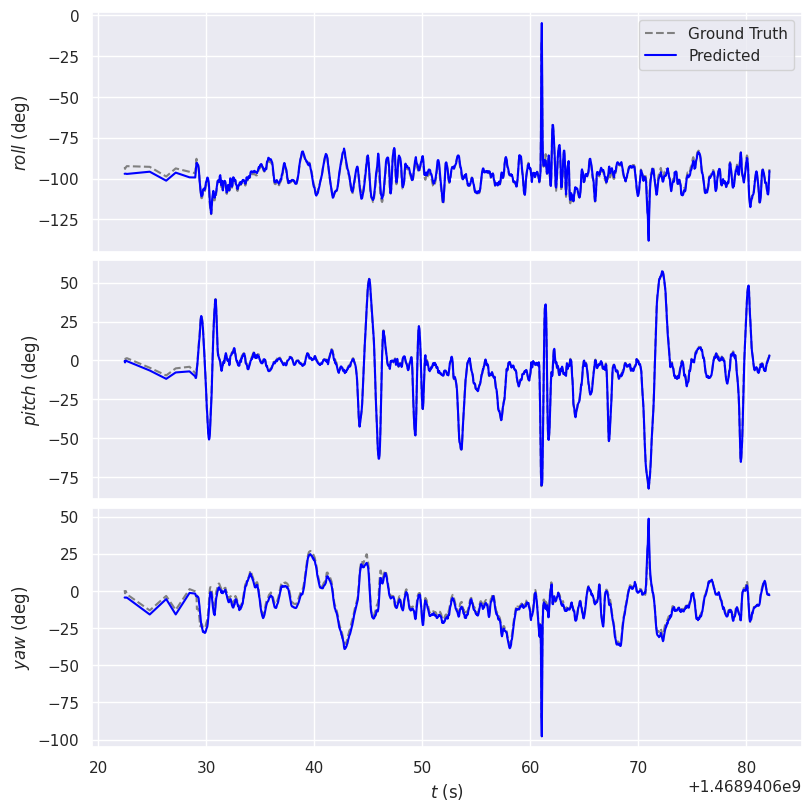

hdr_poster: 
ATE[cm]: 3.87 | MPE[%/m]: 0.06  | rmse_degree[deg]: 2.46 | MRE[deg/m]: 0.04


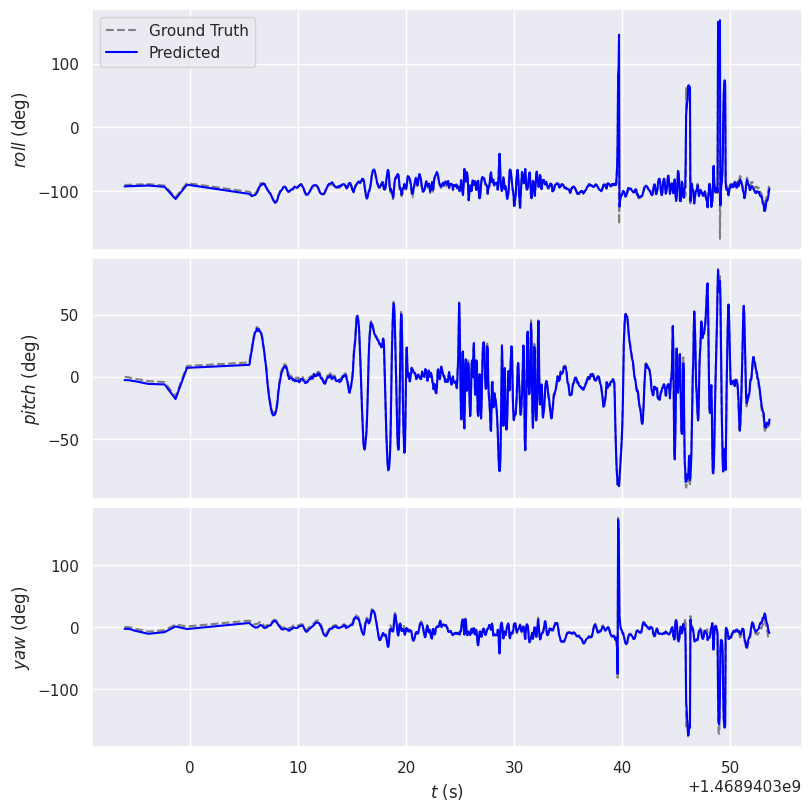

poster_6dof: 
ATE[cm]: 6.19 | MPE[%/m]: 0.08  | rmse_degree[deg]: 3.84 | MRE[deg/m]: 0.05


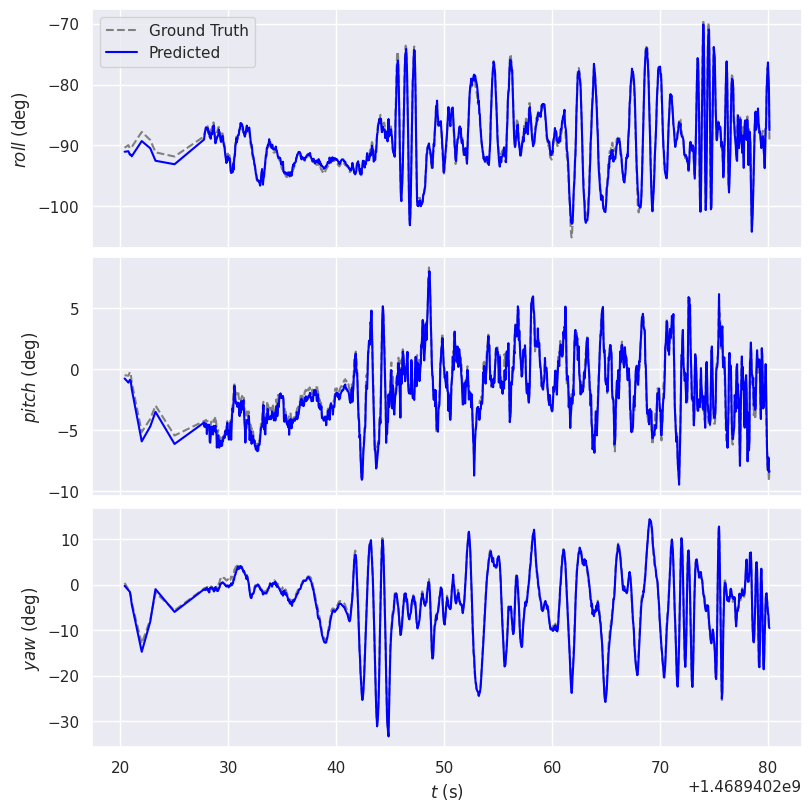

poster_translation: 
ATE[cm]: 2.17 | MPE[%/m]: 0.04  | rmse_degree[deg]: 1.14 | MRE[deg/m]: 0.02


In [6]:
def plot_trajectory_rpy(pred_traj, gt_traj, align=True, _n_to_align=-1,correct_scale=True, max_diff_sec=1.0,title="", filename=""):
#将两个轨迹对齐(时间维度上的)
    gt_traj, pred_traj = sync.associate_trajectories(gt_traj, pred_traj, max_diff=max_diff_sec)
    # 对齐轨迹(空间维度上的)
    if align:
        try:
            pred_traj.align(gt_traj, correct_scale=correct_scale,n=_n_to_align)
        except GeometryException as e:
            print("Plotting error:", e)

    plot_collection = plot.PlotCollection("PlotCol")
    fig_rpy, axarr_rpy = plt.subplots(3, sharex="col",figsize=(8, 8))
    
    plot.traj_rpy(axarr_rpy, gt_traj, '--', 'gray', "Ground Truth")
    plot.traj_rpy(axarr_rpy, pred_traj, '-', 'blue', "Predicted")
    plt.show()


print("Evaluation for DAVIS240c dataset")
indir="/media/lfl-data2/davis240c/"# your dataset path
cur_dir=os.getcwd() #current file directoin

target_dirs = {
                "boxes_6dof",
                "boxes_translation",
                "dynamic_6dof",
                "dynamic_translation",
                "hdr_boxes",
                "hdr_poster",
                "poster_6dof",
                "poster_translation",
                }

for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            tss_gt_us, traj_gt = load_gt_us(os.path.join(datapath_val, f"raw_gt_stamped_ns_left.txt"))#获取真实轨迹

            # 获取deio估算的轨迹
            if sequence_name == "boxes_6dof":
                tss_deio_us, traj_deio = load_gt_us(os.path.join(cur_dir,"./DAVIS240C/2024-10-06_boxes_6dof/Boxes_6Dof_Trial01.txt"))
            elif sequence_name == "boxes_translation":
                tss_deio_us, traj_deio = load_gt_us(os.path.join(cur_dir,"./DAVIS240C/2024-10-06_boxes_translation/Boxes_Translation_Trial01.txt"))
            elif sequence_name == "dynamic_6dof":
                tss_deio_us, traj_deio = load_gt_us(os.path.join(cur_dir,"./DAVIS240C/2024-10-06_dynamic_6dof/Dynamic_6Dof_Trial01.txt"))
            elif sequence_name == "dynamic_translation":
                tss_deio_us, traj_deio = load_gt_us(os.path.join(cur_dir,"./DAVIS240C/2024-10-06_dynamic_translation/Dynamic_Translation_Trial01.txt"))
            elif sequence_name == "hdr_boxes":
                tss_deio_us, traj_deio = load_gt_us(os.path.join(cur_dir,"./DAVIS240C/2024-10-06_hdr_boxes/Hdr_Boxes_Trial01.txt"))
            elif sequence_name == "hdr_poster":
                tss_deio_us, traj_deio = load_gt_us(os.path.join(cur_dir,"./DAVIS240C/2024-10-06_hdr_poster/Hdr_Poster_Trial01.txt"))   
            elif sequence_name == "poster_6dof":
                tss_deio_us, traj_deio = load_gt_us(os.path.join(cur_dir,"./DAVIS240C/2024-10-06_poster_6dof/Poster_6Dof_Trial01.txt"))
            elif sequence_name == "poster_translation":
                tss_deio_us, traj_deio = load_gt_us(os.path.join(cur_dir,"./DAVIS240C/2024-10-06_poster_translation/Poster_Translation_Trial01.txt"))         

            evoGT = make_evo_traj_gt(traj_gt, tss_gt_us)
            evoEst = make_evo_traj_deio(traj_deio, tss_deio_us)
            gtlentraj = evoGT.get_infos()["path length (m)"]#获取轨迹长度
            evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
            _n_to_align=1000;
            ape_trans = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.translation_part, align=True,n_to_align=_n_to_align, correct_scale=True)

            # print(f"\033[31m EVO结果：{ape_trans}\033[0m");
            MPE = ape_trans.stats["mean"] / gtlentraj * 100
            # print(f"MPE is {MPE:.02f}") #注意只保留两位小数
            evoATE = ape_trans.stats["rmse"]*100

            # res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}"

            # 添加角度的验证
            ape_rotation = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.rotation_angle_deg, align=True,n_to_align=_n_to_align, correct_scale=True)
            MRE = ape_rotation.stats["mean"]/ gtlentraj #以度为单位的均值
            rmse_degree = ape_rotation.stats["rmse"]
            res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}  | rmse_degree[deg]: {rmse_degree:.02f} | MRE[deg/m]: {MRE:.02f}"

            %matplotlib inline
            plot_trajectory_rpy(copy.deepcopy(evoGT), copy.deepcopy(evoEst),_n_to_align=_n_to_align);
            
            print(f"{sequence_name}: {res_str}")
            
    # 使用break限制os.walk只遍历indir的第一层
    break

